In [1]:
import math
from typing import List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from labml_nn.diffusion.stable_diffusion.model.unet_attention import SpatialTransformer
from tqdm import tqdm

In [2]:
import subprocess

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda', index=1)

In [3]:
device = "cpu"

In [5]:
class UNetModel(nn.Module):
    """
    ## U-Net model
    """

    def __init__(
            self, *,
            in_channels: int,
            out_channels: int,
            channels: int,
            n_res_blocks: int,
            attention_levels: List[int],
            channel_multipliers: List[int],
            n_heads: int,
            tf_layers: int = 1,
            d_cond: int = 768):
        """
        :param in_channels: is the number of channels in the input feature map
        :param out_channels: is the number of channels in the output feature map
        :param channels: is the base channel count for the model
        :param n_res_blocks: number of residual blocks at each level
        :param attention_levels: are the levels at which attention should be performed
        :param channel_multipliers: are the multiplicative factors for number of channels for each level
        :param n_heads: is the number of attention heads in the transformers
        :param tf_layers: is the number of transformer layers in the transformers
        :param d_cond: is the size of the conditional embedding in the transformers
        """
        super().__init__()
        self.channels = channels

        # Number of levels
        levels = len(channel_multipliers)
        # Size time embeddings
        d_time_emb = channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(channels, d_time_emb),
            nn.SiLU(),
            nn.Linear(d_time_emb, d_time_emb),
        )

        # Input half of the U-Net
        self.input_blocks = nn.ModuleList()
        # Initial $3 \times 3$ convolution that maps the input to `channels`.
        # The blocks are wrapped in `TimestepEmbedSequential` module because
        # different modules have different forward function signatures;
        # for example, convolution only accepts the feature map and
        # residual blocks accept the feature map and time embedding.
        # `TimestepEmbedSequential` calls them accordingly.
        self.input_blocks.append(TimestepEmbedSequential(
            nn.Conv2d(in_channels, channels, 3, padding=1)))
        # Number of channels at each block in the input half of U-Net
        input_block_channels = [channels]
        # Number of channels at each level
        channels_list = [channels * m for m in channel_multipliers]
        # Prepare levels
        for i in range(levels):
            # Add the residual blocks and attentions
            for _ in range(n_res_blocks):
                # Residual block maps from previous number of channels to the number of
                # channels in the current level
                layers = [ResBlock(channels, d_time_emb, out_channels=channels_list[i])]
                channels = channels_list[i]
                # Add transformer
                if i in attention_levels:
                    layers.append(SpatialTransformer(channels, n_heads, tf_layers, d_cond))
                # Add them to the input half of the U-Net and keep track of the number of channels of
                # its output
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_channels.append(channels)
            # Down sample at all levels except last
            if i != levels - 1:
                self.input_blocks.append(TimestepEmbedSequential(DownSample(channels)))
                input_block_channels.append(channels)

        # The middle of the U-Net
        self.middle_block = TimestepEmbedSequential(
            ResBlock(channels, d_time_emb),
            SpatialTransformer(channels, n_heads, tf_layers, d_cond),
            ResBlock(channels, d_time_emb),
        )

        # Second half of the U-Net
        self.output_blocks = nn.ModuleList([])
        # Prepare levels in reverse order
        for i in reversed(range(levels)):
            # Add the residual blocks and attentions
            for j in range(n_res_blocks + 1):
                # Residual block maps from previous number of channels plus the
                # skip connections from the input half of U-Net to the number of
                # channels in the current level.
                layers = [ResBlock(channels + input_block_channels.pop(), d_time_emb, out_channels=channels_list[i])]
                channels = channels_list[i]
                # Add transformer
                if i in attention_levels:
                    layers.append(SpatialTransformer(channels, n_heads, tf_layers, d_cond))
                # Up-sample at every level after last residual block
                # except the last one.
                # Note that we are iterating in reverse; i.e. `i == 0` is the last.
                if i != 0 and j == n_res_blocks:
                    layers.append(UpSample(channels))
                # Add to the output half of the U-Net
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        # Final normalization and $3 \times 3$ convolution
        self.out = nn.Sequential(
            normalization(channels),
            nn.SiLU(),
            nn.Conv2d(channels, out_channels, 3, padding=1),
        )

    def time_step_embedding(self, time_steps: torch.Tensor, max_period: int = 10000):
        """
        ## Create sinusoidal time step embeddings

        :param time_steps: are the time steps of shape `[batch_size]`
        :param max_period: controls the minimum frequency of the embeddings.
        """
        # $\frac{c}{2}$; half the channels are sin and the other half is cos,
        half = self.channels // 2
        # $\frac{1}{10000^{\frac{2i}{c}}}$
        frequencies = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=time_steps.device)
        # $\frac{t}{10000^{\frac{2i}{c}}}$
        args = time_steps[:, None].float() * frequencies[None]
        # $\cos\Bigg(\frac{t}{10000^{\frac{2i}{c}}}\Bigg)$ and $\sin\Bigg(\frac{t}{10000^{\frac{2i}{c}}}\Bigg)$
        return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

    def forward(self, x: torch.Tensor, time_steps: torch.Tensor, cond: torch.Tensor):
        """
        :param x: is the input feature map of shape `[batch_size, channels, width, height]`
        :param time_steps: are the time steps of shape `[batch_size]`
        :param cond: conditioning of shape `[batch_size, n_cond, d_cond]`
        """
        # To store the input half outputs for skip connections
        x_input_block = []

        # Get time step embeddings
        t_emb = self.time_step_embedding(time_steps)
        t_emb = self.time_embed(t_emb)

        # Input half of the U-Net
        for module in self.input_blocks:
            x = module(x, t_emb, cond)
            x_input_block.append(x)
        # Middle of the U-Net
        x = self.middle_block(x, t_emb, cond)
        # Output half of the U-Net
        for module in self.output_blocks:
            x = torch.cat([x, x_input_block.pop()], dim=1)
            x = module(x, t_emb, cond)

        # Final normalization and $3 \times 3$ convolution
        return self.out(x)


class TimestepEmbedSequential(nn.Sequential):
    """
    ### Sequential block for modules with different inputs

    This sequential module can compose of different modules such as `ResBlock`,
    `nn.Conv` and `SpatialTransformer` and calls them with the matching signatures
    """

    def forward(self, x, t_emb, cond=None):
        for layer in self:
            if isinstance(layer, ResBlock):
                x = layer(x, t_emb)
            elif isinstance(layer, SpatialTransformer):
                x = layer(x, cond)
            else:
                x = layer(x)
        return x


class UpSample(nn.Module):
    """
    ### Up-sampling layer
    """

    def __init__(self, channels: int):
        """
        :param channels: is the number of channels
        """
        super().__init__()
        # $3 \times 3$ convolution mapping
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x: torch.Tensor):
        """
        :param x: is the input feature map with shape `[batch_size, channels, height, width]`
        """
        # Up-sample by a factor of $2$
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        # Apply convolution
        return self.conv(x)


class DownSample(nn.Module):
    """
    ## Down-sampling layer
    """

    def __init__(self, channels: int):
        """
        :param channels: is the number of channels
        """
        super().__init__()
        # $3 \times 3$ convolution with stride length of $2$ to down-sample by a factor of $2$
        self.op = nn.Conv2d(channels, channels, 3, stride=2, padding=1)

    def forward(self, x: torch.Tensor):
        """
        :param x: is the input feature map with shape `[batch_size, channels, height, width]`
        """
        # Apply convolution
        return self.op(x)


class ResBlock(nn.Module):
    """
    ## ResNet Block
    """

    def __init__(self, channels: int, d_t_emb: int, *, out_channels=None):
        """
        :param channels: the number of input channels
        :param d_t_emb: the size of timestep embeddings
        :param out_channels: is the number of out channels. defaults to `channels.
        """
        super().__init__()
        # `out_channels` not specified
        if out_channels is None:
            out_channels = channels

        # First normalization and convolution
        self.in_layers = nn.Sequential(
            normalization(channels),
            nn.SiLU(),
            nn.Conv2d(channels, out_channels, 3, padding=1),
        )

        # Time step embeddings
        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(d_t_emb, out_channels),
        )
        # Final convolution layer
        self.out_layers = nn.Sequential(
            normalization(out_channels),
            nn.SiLU(),
            nn.Dropout(0.),
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )

        # `channels` to `out_channels` mapping layer for residual connection
        if out_channels == channels:
            self.skip_connection = nn.Identity()
        else:
            self.skip_connection = nn.Conv2d(channels, out_channels, 1)

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor):
        """
        :param x: is the input feature map with shape `[batch_size, channels, height, width]`
        :param t_emb: is the time step embeddings of shape `[batch_size, d_t_emb]`
        """
        # Initial convolution
        h = self.in_layers(x)
        # Time step embeddings
        t_emb = self.emb_layers(t_emb).type(h.dtype)
        # Add time step embeddings
        h = h + t_emb[:, :, None, None]
        # Final convolution
        h = self.out_layers(h)
        # Add skip connection
        return self.skip_connection(x) + h


class GroupNorm32(nn.GroupNorm):
    """
    ### Group normalization with float32 casting
    """

    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)


def normalization(channels):
    """
    ### Group normalization

    This is a helper function, with fixed number of groups..
    """
    return GroupNorm32(32, channels)


def _test_time_embeddings():
    """
    Test sinusoidal time step embeddings
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 5))
    m = UNetModel(in_channels=1, out_channels=1, channels=320, n_res_blocks=1, attention_levels=[],
                  channel_multipliers=[],
                  n_heads=1, tf_layers=1, d_cond=1)
    te = m.time_step_embedding(torch.arange(0, 1000))
    plt.plot(np.arange(1000), te[:, [50, 100, 190, 260]].numpy())
    plt.legend(["dim %d" % p for p in [50, 100, 190, 260]])
    plt.title("Time embeddings")
    plt.show()

In [6]:
in_channels = 1
out_channels = 1
channels = 32
n_res_block = 2
attention_levels = [1,2]
channel_multipliers = [2, 3]
n_heads = 2
tf_layers = 1
d_cond = 768

In [7]:
class LinearNoiseScheduler:
    r"""
    Class for the linear noise scheduler that is used in DDPM.
    """
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0).to(device)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod).to(device)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod).to(device)
        
    def add_noise(self, original, noise, t):
        r"""
        Forward method for diffusion
        :param original: Image on which noise is to be applied
        :param noise: Random Noise Tensor (from normal dist)
        :param t: timestep of the forward process of shape -> (B,)
        :return:
        """
        original_shape = original.shape
        batch_size = original_shape[0]
        
        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)
        
        # Reshape till (B,) becomes (B,1,1,1) if image is (B,C,H,W)
        for _ in range(len(original_shape)-1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
        for _ in range(len(original_shape)-1):
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        # Apply and Return Forward process equation
        return (sqrt_alpha_cum_prod.to(original.device) * original
                + sqrt_one_minus_alpha_cum_prod.to(original.device) * noise)
        
    def sample_prev_timestep(self, xt, noise_pred, t):
        r"""
            Use the noise prediction by model to get
            xt-1 using xt and the nosie predicted
        :param xt: current timestep sample
        :param noise_pred: model noise prediction
        :param t: current timestep we are at
        :return:
        """
        x0 = (xt - (self.sqrt_one_minus_alpha_cum_prod[t] * noise_pred)) / torch.sqrt(self.alpha_cum_prod[t])
        x0 = torch.clamp(x0, -1., 1.)

        mean = xt - ((self.betas[t])*noise_pred)/(self.sqrt_one_minus_alpha_cum_prod[t])
        mean = mean / torch.sqrt(self.alphas[t])
        
        if t == 0:
            return mean, mean
        else:
            variance = (1-self.alpha_cum_prod[t-1]) / (1.0 - self.alpha_cum_prod[t])
            variance = variance * self.betas[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)
            
            # OR
            # variance = self.betas[t]
            # sigma = variance ** 0.5
            # z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma*z, x0

    def sample_prev_timestep_ddim (self, xt, noise_pred, t, prev_t):

        x0 = (xt - self.sqrt_one_minus_alpha_cum_prod[t]*noise_pred) / torch.sqrt(self.alpha_cum_prod[t])
        x0 = torch.clamp(x0, -1., 1.)
        xt_prev = self.sqrt_alpha_cum_prod[prev_t] * x0 + self.sqrt_one_minus_alpha_cum_prod[prev_t]*noise_pred
        return xt_prev, x0

In [8]:
u_net_model = UNetModel(in_channels=in_channels, out_channels=out_channels, channels=channels, n_res_blocks=n_res_block,
                        attention_levels=attention_levels, channel_multipliers=channel_multipliers, n_heads=n_heads, 
                        tf_layers=tf_layers, d_cond=d_cond).to(device)
ls = LinearNoiseScheduler(1000, 1e-4, 0.02)

In [9]:
u_net_model.train()

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=128, out_features=64, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.0, inplace=False)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection): C

In [10]:
# load mnist dataset and make dataloader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

/home/reddyanugu/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/reddyanugu/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [11]:
num_epochs = 20
optimizer = torch.optim.Adam(u_net_model.parameters(), lr=0.0001)
loss_array = []

In [ ]:
for epoch in tqdm(range(num_epochs)):
    for batch in trainloader:
        im = batch[0].to(device)
        t = torch.randint(0, 1000, (32,)).to(device)
        cond = torch.zeros(32, 1, 768).to(device)
        noise = torch.randn(32, 1, 28, 28).to(device)
        xt = ls.add_noise(im, noise, t).to(device)
        noise_pred = u_net_model(xt, t, cond)
        loss = F.mse_loss(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_array.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

In [11]:
u_net_model.eval()

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=128, out_features=64, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.0, inplace=False)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (skip_connection): C

In [ ]:
# save the parameters of u_net_model
torch.save(u_net_model.state_dict(), 'u_net_model.pth')

In [12]:
u_net_model.load_state_dict(torch.load('aq_model.pth'))

<All keys matched successfully>

In [13]:
def get_gpu_memory_usage():
    result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,nounits'],
                            stdout=subprocess.PIPE, text=True)
    
    # The output will be in the form 'memory.used\n1234\n5678\n...'
    # Extract the numeric values
    memory_used_values = [int(value) for value in result.stdout.strip().split('\n')[1:]]

    return memory_used_values

In [69]:
def generate_image (ddim=False, end_timestep=999, skip=10):
    # memory_used_values = get_gpu_memory_usage()
    # print("GPU Memory Usage:", memory_used_values[1])
    xt = torch.randn(100, 1, 28, 28).to(device)
    cond = torch.zeros(100, 1, 768).to(device)
    # memory_used_values = get_gpu_memory_usage()
    # print("GPU Memory Usage:", memory_used_values[1])
    if ddim:
        timestamps = torch.arange(end_timestep, 0, -1*skip)[:, None].to(device)
    else:
        timestamps = torch.arange(end_timestep, 0, -1)[:, None].to(device)
    for t in tqdm(timestamps):
        index = torch.where(timestamps == t)[0]
        with torch.no_grad():
            noise_pred = u_net_model(xt, t, cond)
            if ddim:
                if (index + 1) != len(timestamps):
                    xt, x0 = ls.sample_prev_timestep_ddim(xt, noise_pred, t, timestamps[index+1])
            else:
                xt, x0 = ls.sample_prev_timestep(xt, noise_pred, t)
    return xt

In [32]:
for x, y in trainloader:
    real_images = x
    break

In [70]:
images = generate_image()

100%|██████████| 999/999 [00:17<00:00, 56.51it/s]


In [71]:
images_ddim = generate_image(ddim=True, end_timestep=999, skip=2)

100%|██████████| 500/500 [00:08<00:00, 59.13it/s]


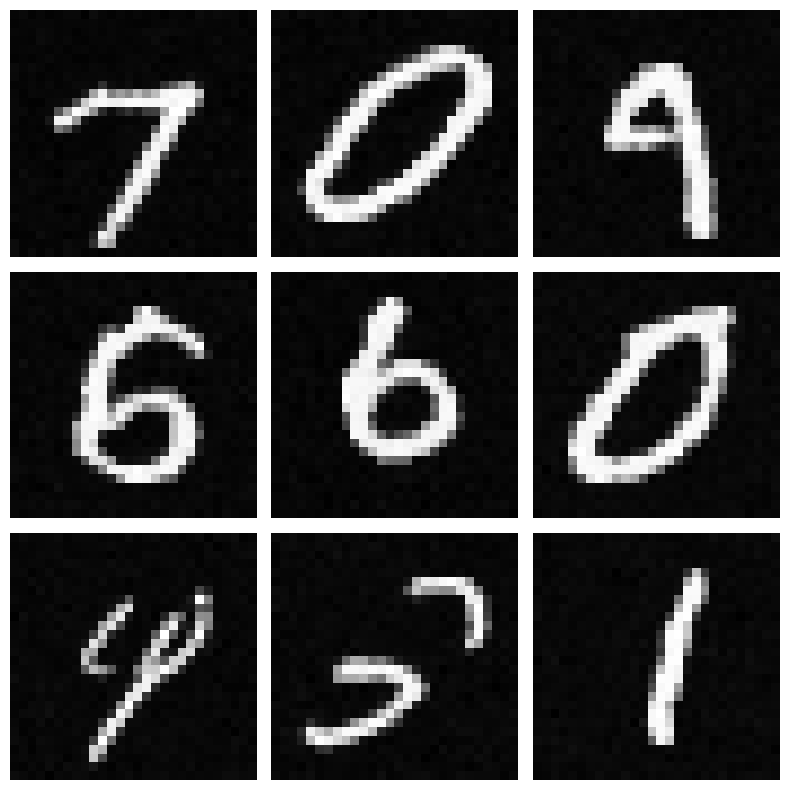

In [72]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

# Iterate through the images and plot them on the subplots
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i][0, :, :].detach().cpu().numpy(), cmap='gray')
    ax.axis('off')  # Hide axes for better visualization

plt.tight_layout()
plt.show()

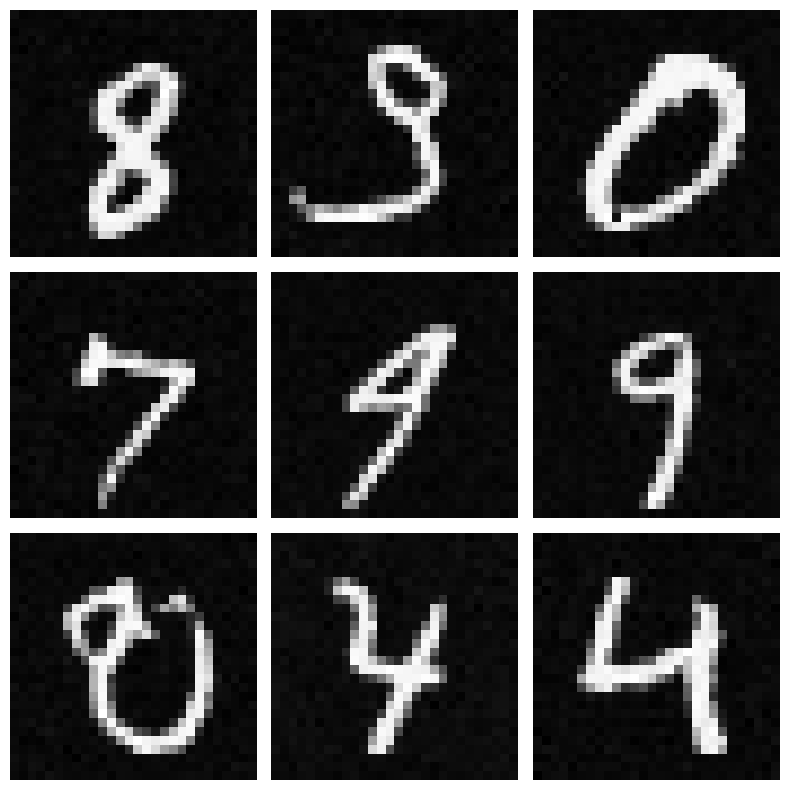

In [73]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

# Iterate through the images and plot them on the subplots
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images_ddim[i][0, :, :].detach().cpu().numpy(), cmap='gray')
    ax.axis('off')  # Hide axes for better visualization

plt.tight_layout()
plt.show()

In [23]:
from torchvision.models import inception_v3

In [24]:
from sklearn.decomposition import PCA

In [74]:
images_ddim.shape

torch.Size([100, 1, 28, 28])

In [75]:
mean_real = real_images.squeeze().reshape(-1, 28*28).detach().cpu().mean(axis=0).numpy()
mean_images = images.squeeze().reshape(-1, 28*28).detach().cpu().mean(axis=0).numpy()
mean_images_ddim = images_ddim.squeeze().reshape(-1, 28*28).detach().cpu().mean(axis=0).numpy()

cov_real = np.cov(real_images.squeeze().reshape(-1, 28*28).detach().cpu(), rowvar=False)
cov_images = np.cov(images.squeeze().reshape(-1, 28*28).detach().cpu(), rowvar=False)
cov_images_ddim = np.cov(images_ddim.squeeze().reshape(-1, 28*28).detach().cpu(), rowvar=False)

In [76]:
def calculate_fid (mu_1, mu_2, cov_1, cov2):
    ssdiff = np.sum((mu_1 - mu_2)**2.0)
    covmean = sqrtm(cov_1.dot(cov2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(cov_1 + cov2 - 2.0 * covmean)
    return fid

In [77]:
calculate_fid(mean_real, mean_images, cov_real, cov_images)

41.81463346164411

In [78]:
calculate_fid(mean_real, mean_images_ddim, cov_real, cov_images_ddim)

39.504593738400914